# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional notes:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding;
* You may import any libraries you need to complete the assignment. However, you must implement the model using TensorFlow (do not use PyTorch);
* Follow the same steps/idea as in Assignment 4; the difference here is that you extend a logistic model to more than two classes;
* <span style="color:chocolate"> Focus on the execution of the task rather than model performance </span> (this is how the TA will grade your work);
* Even though the prediction performance for your chosen outcome is low, it doesn't necessarily mean there is something wrong with your implementation. It could also be that the data is not supportive enough for your prediction task... again, focus on the learning opportunity and not the numbers you get;
* Your instructional team has extensive experience developing and running ML models. Often, we encounter situations where a model doesn't perform well on a predictive task. This can happen due to the nature of the data or the need for significant tweaking of variables to achieve good results;
* Do not spend significantly more time on this task than you did on Assignment 4, unless you wish to experiment and learn more.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task.


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [2]:
!pip install keras_tuner

In [3]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from tensorflow.keras import initializers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from keras_tuner import HyperParameters
import keras.backend as K

# feel free to import other libraries as needed

import warnings
warnings.filterwarnings('ignore')

In [4]:
import sklearn.metrics

### Define functions

In [5]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )

    return df

In [6]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15

    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [7]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [8]:
# YOUR CODE HERE

print("1. Number of columns in dataset:", len(df.columns))
print("\n2. Number of rows in dataset:", len(df))
print("\n3. Column names:")
print(df.columns)
print("\n4. Number of unique values for each column:")
print(df.nunique(axis=0))
print("\n5. Unique cocoa_percent values:")
print(df["cocoa_percent"].unique())

1. Number of columns in dataset: 9

2. Number of rows in dataset: 1795

3. Column names:
Index(['maker', 'specific_origin', 'reference_number', 'review_date',
       'cocoa_percent', 'maker_location', 'rating', 'bean_type',
       'broad_origin'],
      dtype='object')

4. Number of unique values for each column:
maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64

5. Unique cocoa_percent values:
[ 63.   70.   60.   80.   88.   72.   55.   75.   65.   85.   73.   64.
  66.   68.   50.  100.   77.   90.   71.   83.   78.   74.   76.   86.
  82.   69.   91.   42.   61.   73.5  62.   67.   58.   60.5  79.   81.
  57.   72.5  56.   46.   89.   99.   84.   53.   87. ]


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here:

In [9]:
# YOUR CODE HERE

# Choosing bean_type as a multiclass outcome variable
print("Choosing bean_type as multiclass outcome variable:")
print(df["bean_type"].unique())

# Recoding class labels (starting from 0)
class_mapping = {label: idx for idx, label in enumerate(df["bean_type"].unique())}

# Creating a new column for bean_type class (called "bt_class") with those numbers
df["bt_class"] = df["bean_type"].map(class_mapping)

# Checking bt_class:
print("\nPrinting bt_class (\"bean type\" class) outcome variables:")
print(df["bt_class"].unique())

Choosing bean_type as multiclass outcome variable:
['Blend' 'Criollo' 'Trinitario' 'Forastero (Arriba)' 'Forastero'
 'Forastero (Nacional)' 'Criollo, Trinitario' 'Criollo (Porcelana)'
 'Trinitario (85% Criollo)' 'Forastero (Catongo)' 'Forastero (Parazinho)'
 'CCN51' 'Criollo (Ocumare)' 'Nacional' 'Criollo (Ocumare 61)'
 'Criollo (Ocumare 77)' 'Criollo (Ocumare 67)' 'Criollo (Wild)' 'Beniano'
 'Amazon mix' 'Trinitario, Forastero' 'Forastero (Arriba) ASS'
 'Criollo, +' 'Amazon' 'Amazon, ICS' 'EET' 'Blend-Forastero,Criollo'
 'Trinitario (Scavina)' 'Criollo, Forastero' 'Matina'
 'Forastero(Arriba, CCN)' 'Nacional (Arriba)' 'Forastero (Arriba) ASSS'
 'Forastero, Trinitario' 'Forastero (Amelonado)' 'Trinitario, Nacional'
 'Trinitario (Amelonado)' 'Trinitario, TCGA' 'Criollo (Amarru)']

Printing bt_class ("bean type" class) outcome variables:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


In [10]:
# Analyzing the value counts in each class for bt_class

# Printing the value counts of each class in bt_class
print(df["bt_class"].value_counts(), '\n')

print("We see that many of the classes in bean_type have only one observation")
print("associated with them, which is slightly problematic for 2 reasons.")
print("Firstly, our model likely wouldn't generalize well to those results, as")
print("there is so little data pointing to those minority classes. Secondly,")
print("this will interfere with the machine learning, as the model assumes")
print("that the class sizes are roughly equal. Therefore, to improve the")
print("efficacy of our model, we can set a threshold of observations that each")
print("chosen class must meet.\n")

bt_class
0     929
2     419
1     153
4      87
5      52
     ... 
12      1
23      1
22      1
15      1
11      1
Name: count, Length: 39, dtype: int64 

We see that many of the classes in bean_type have only one observation
associated with them, which is slightly problematic for 2 reasons.
Firstly, our model likely wouldn't generalize well to those results, as
there is so little data pointing to those minority classes. Secondly,
this will interfere with the machine learning, as the model assumes
that the class sizes are roughly equal. Therefore, to improve the
efficacy of our model, we can set a threshold of observations that each
chosen class must meet.



In [11]:
# Choosing a threshold of observations that each class must meet

print(df["bt_class"].value_counts()[:15], '\n')

print("Looking at the first 15 results, we see a somewhat large dropoff in the")
print("count of classes from bt_class 3 to 7. Therefore, setting a threshold")
print("somewhere between those 2 values (e.g., 20 observations minimum), will")
print("ensure that only the majority classes above 20 observations will be")
print("included in our model.")

bt_class
0     929
2     419
1     153
4      87
5      52
6      48
3      37
7      10
10      8
21      6
18      3
29      3
25      3
31      3
28      2
Name: count, dtype: int64 

Looking at the first 15 results, we see a somewhat large dropoff in the
count of classes from bt_class 3 to 7. Therefore, setting a threshold
somewhere between those 2 values (e.g., 20 observations minimum), will
ensure that only the majority classes above 20 observations will be
included in our model.


In [12]:
# Getting the top classes with the most observations
over_20_obs = df["bt_class"].value_counts() >= 20
over_20_obs = over_20_obs[over_20_obs]

# Creating cleaned dataframe with only observations greater than 20
df_clean = df[df["bt_class"].isin(over_20_obs.index)]

# Confirming the value_counts
print(df_clean["bt_class"].value_counts(), '\n')

print("We now have 7 classes that we can analyze, though we notice the other")
print("problem of our majority class having more observations than all the")
print("other classes combined. We can solve this by undersampling all classes")
print("so that they have the same number of observations as the minority class")
print("(class 3), and making sure that the observations are randomly selected.")

bt_class
0    929
2    419
1    153
4     87
5     52
6     48
3     37
Name: count, dtype: int64 

We now have 7 classes that we can analyze, though we notice the other
problem of our majority class having more observations than all the
other classes combined. We can solve this by undersampling all classes
so that they have the same number of observations as the minority class
(class 3), and making sure that the observations are randomly selected.


In [13]:
np.random.seed(0)
# Undersampling to get class sizes roughly equal

# Getting the minimum observations for bt_class
min_obs = min(df_clean["bt_class"].value_counts())

# Randomizing the indices, and dropping observations that are over 37
for i in range(len(over_20_obs)):
  class_indices = df_clean[df_clean["bt_class"] == i].index
  class_indices_shuffled = np.random.permutation(class_indices)
  class_indices_dropped = class_indices_shuffled[min_obs:]
  df_clean = df_clean.drop(class_indices_dropped)

# Reindexing df_clean to start from 0
df_clean = df_clean.reset_index(drop=True)

print("Shape of df_clean after undersampling:", df_clean.shape, '\n')
print("Value counts for bt_class after undersampling:")
print(df_clean["bt_class"].value_counts(), '\n')

print("Now we have undersampled our data so that they all have the same number")
print("of observations. With that done, we can prepare the rest of the")
print("features for modeling.")

Shape of df_clean after undersampling: (259, 10) 

Value counts for bt_class after undersampling:
bt_class
1    37
0    37
2    37
3    37
5    37
6    37
4    37
Name: count, dtype: int64 

Now we have undersampled our data so that they all have the same number
of observations. With that done, we can prepare the rest of the
features for modeling.


---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

In [14]:
# YOUR CODE HERE
np.random.seed(0)

# 1. Shuffling the dataset
indices = np.arange(df_clean.shape[0])
shuffled_indices = np.random.permutation(indices)

# Reordering df based on the order in shuffled_indices
df_clean = df_clean.reindex(shuffled_indices)

# Creating df for X and df for Y
df_X = df_clean.iloc[:,:-1]
df_X = df_X.drop("bean_type", axis = 1) # Dropping bean_type
df_Y = df_clean.iloc[:,-1]

In [15]:
# 2. Creating training, validation, and test datasets using a 60/20/20 split
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size = 0.2,
  random_state = 1234)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
  test_size = 0.25, random_state = 1234)

print("Printing the shape of X_train:", X_train.shape)
print("Printing the shape of X_val:", X_val.shape)
print("Printing the shape of X_test:", X_test.shape)
print("Printing the shape of Y_train:", Y_train.shape)
print("Printing the shape of Y_val:", Y_val.shape)
print("Printing the shape of Y_test:", Y_test.shape)

Printing the shape of X_train: (155, 8)
Printing the shape of X_val: (52, 8)
Printing the shape of X_test: (52, 8)
Printing the shape of Y_train: (155,)
Printing the shape of Y_val: (52,)
Printing the shape of Y_test: (52,)


In [16]:
# 3. Identifying the features of interest

print("Getting the unique value counts of X_train")
print(X_train.nunique(), '\n')

print("Looking back on the Kaggle website where this dataset was pulled from,")
print("there are some features that we can likely exclude for determining the")
print("the bean type of a chocolate bar. Specifically, reference_number and")
print("review_date are mainly logistical data, and they serve as ways to")
print("identify what review was entered into the database and when it was")
print("entered. We can likely exclude specific_origin as well, as 1) it seems")
print("to be a subset of broad_origin, and 2) examining the unique value")
print("counts tells us that many entries have unique specific origins, making")
print("making it not very generalizable. The maker feature also suffers from")
print("similar issues, as it's very specific, and it could be redundant as we")
print("have the maker_location as well. However, I would contend that")
print("maker_location might also not be very informative for predicting the")
print("bean_type, as that's simply where the chocolate bar itself is")
print("manufactured. It might be the case where certain regions only use")
print("certain bean types, but that specificity might decrease the")
print("generalizability of the model as well.\n")

print("Therefore, the 3 features that we will keep to analyze the bean_type")
print("will be cocoa_percent, rating, and broad_origin. The reasoning for each")
print("are as follows:")
print(" - cocoa_percent: likely specific to bean_type, & even if it's blended,")
print("it might still give us insight into what type of bean it could be")
print(" - rating: chocolate bars made with certain bean types will likely have")
print("different ratings from those made from other bean types")
print(" - broad_origin: the broad region where a bean comes from will likely")
print("be informative to what the type of the bean is, as certain beans might")
print("only grow in certain regions")

Getting the unique value counts of X_train
maker               104
specific_origin     130
reference_number    128
review_date          12
cocoa_percent        24
maker_location       24
rating               10
broad_origin         32
dtype: int64 

Looking back on the Kaggle website where this dataset was pulled from,
there are some features that we can likely exclude for determining the
the bean type of a chocolate bar. Specifically, reference_number and
review_date are mainly logistical data, and they serve as ways to
identify what review was entered into the database and when it was
entered. We can likely exclude specific_origin as well, as 1) it seems
to be a subset of broad_origin, and 2) examining the unique value
counts tells us that many entries have unique specific origins, making
making it not very generalizable. The maker feature also suffers from
similar issues, as it's very specific, and it could be redundant as we
have the maker_location as well. However, I would contend

In [17]:
# 4. Performing necessary cleaning and standardization of features

# Only keeping the columns that we're interested in
columns_to_keep = ['cocoa_percent', 'rating', 'broad_origin']
X_train = X_train[columns_to_keep]
X_val = X_val[columns_to_keep]
X_test = X_test[columns_to_keep]

# Checking to make sure there are no null values in any of the columns
print("Checking for X_train null values:")
print(X_train.isna().sum(), '\n')
print("Checking for X_val null values:")
print(X_val.isna().sum(), '\n')
print("Checking for X_test null values:")
print(X_test.isna().sum(), '\n')

# Getting train, val, and test dummy variables for broad_origin
broad_origin_train_d = pd.get_dummies(
    X_train['broad_origin'],
    drop_first = False
)
broad_origin_val_d = pd.get_dummies(
    X_val['broad_origin'],
    drop_first = False
)
broad_origin_test_d = pd.get_dummies(
    X_test['broad_origin'],
    drop_first = False
)
print("Number of X_train dummy variables:", X_train['broad_origin'].nunique())
print("Shape of X_train dummy variable for broad_origin:",
      broad_origin_train_d.shape, '\n')
print("Number of X_val dummy variables:", X_val['broad_origin'].nunique())
print("Shape of X_val dummy variable for broad_origin:",
      broad_origin_val_d.shape, '\n')
print("Number of X_test dummy variables:", X_test['broad_origin'].nunique())
print("Shape of X_test dummy variable for broad_origin:",
      broad_origin_test_d.shape, '\n')

# Adding the dummy variables to X_train, X_val, and X_test
X_train = pd.concat(
    [X_train, broad_origin_train_d],
    axis=1
)
X_val = pd.concat(
    [X_val, broad_origin_val_d],
    axis=1
)
X_test = pd.concat(
    [X_test, broad_origin_test_d],
    axis=1
)


Checking for X_train null values:
cocoa_percent    0
rating           0
broad_origin     0
dtype: int64 

Checking for X_val null values:
cocoa_percent    0
rating           0
broad_origin     0
dtype: int64 

Checking for X_test null values:
cocoa_percent    0
rating           0
broad_origin     0
dtype: int64 

Number of X_train dummy variables: 32
Shape of X_train dummy variable for broad_origin: (155, 32) 

Number of X_val dummy variables: 17
Shape of X_val dummy variable for broad_origin: (52, 17) 

Number of X_test dummy variables: 18
Shape of X_test dummy variable for broad_origin: (52, 18) 



In [18]:
# Reindexing so that val and test datasets have the same columns as the training
# dataset (and the excess columns are removed):
# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
X_val = X_val.reindex(columns = X_train.columns, fill_value=False)
X_test = X_test.reindex(columns = X_train.columns, fill_value=False)

print("Shape of X_train with dummy variables:", X_train.shape)
print("Shape of X_val with dummy variables:", X_val.shape)
print("Shape of X_test with dummy variables:", X_test.shape, '\n')

# Adding in out of sample column for val and test broad origins not in X_train
X_train["out_of_sample"] = False  # Since all of X_train is inherently in sample
X_val["out_of_sample"] = ~X_val.iloc[:,3:].any(axis = 1)
X_test["out_of_sample"] = ~X_test.iloc[:,3:].any(axis = 1)

print("Shape of X_train with out of sample column:", X_train.shape)
print("Shape of X_val with out of sample column:", X_val.shape)
print("Shape of X_test with out of sample column:", X_test.shape, '\n')

print("Number of broad_origin dummies in X_train that are not in X_train:",
  X_train["out_of_sample"].sum())
print("Number of broad_origin dummies in X_val that are not in X_train:",
  X_val["out_of_sample"].sum())
print("Number of broad_origin dummies in X_test that are not in X_train:",
  X_test["out_of_sample"].sum())

Shape of X_train with dummy variables: (155, 35)
Shape of X_val with dummy variables: (52, 35)
Shape of X_test with dummy variables: (52, 35) 

Shape of X_train with out of sample column: (155, 36)
Shape of X_val with out of sample column: (52, 36)
Shape of X_test with out of sample column: (52, 36) 

Number of broad_origin dummies in X_train that are not in X_train: 0
Number of broad_origin dummies in X_val that are not in X_train: 4
Number of broad_origin dummies in X_test that are not in X_train: 1


In [19]:
# Checking which dummies in X_val and X_test are not in X_train
print("Broad origin dummies in X_val that are not in X_train:")
print(set(broad_origin_val_d.columns) - set(broad_origin_train_d.columns))
print("Broad origin dummies in X_test that are not in X_train:")
print(set(broad_origin_test_d.columns) - set(broad_origin_train_d.columns))
print("\nIn X_test, Principe does not appear to be in X_train, whereas in")
print("X_val, Uganda and Cameroon do not appear to be in X_train. What's")
print("interesting is that the other 2 dummies in X_val ('Ghana,Panama,Ecuador'")
print("and 'Colombia,Ecuador') are a combination of countries. Checking the")
print("original broad_origin feature shows us that some of these countries are")
print("in fact in X_train individually:")

X_val_combined_countries = ['Ghana', 'Panama', 'Ecuador', 'Colombia']
for country in X_val_combined_countries:
  print("- Is", country, "in X_train broad_origin?",
        country in set(X_train['broad_origin']))

print("\nEven with this knowledge, it's hard to decipher whether or not this")
print("was intentional, or if it were an accounting error. For now, we will")
print("treat these as their own features, and assume that their broad_origin")
print("types are that way because that's genuinely where the bean types are")
print("from.")

Broad origin dummies in X_val that are not in X_train:
{'Uganda', 'Cameroon', 'Ghana,Panama,Ecuador', 'Colombia,Ecuador'}
Broad origin dummies in X_test that are not in X_train:
{'Principe'}

In X_test, Principe does not appear to be in X_train, whereas in
X_val, Uganda and Cameroon do not appear to be in X_train. What's
interesting is that the other 2 dummies in X_val ('Ghana,Panama,Ecuador'
and 'Colombia,Ecuador') are a combination of countries. Checking the
original broad_origin feature shows us that some of these countries are
in fact in X_train individually:
- Is Ghana in X_train broad_origin? True
- Is Panama in X_train broad_origin? False
- Is Ecuador in X_train broad_origin? True
- Is Colombia in X_train broad_origin? True

Even with this knowledge, it's hard to decipher whether or not this
was intentional, or if it were an accounting error. For now, we will
treat these as their own features, and assume that their broad_origin
types are that way because that's genuinely where t

In [20]:
# Removing broad_origin since we've converted it to one-hot encoding
X_train = X_train.drop("broad_origin", axis = 1)
X_val = X_val.drop("broad_origin", axis = 1)
X_test = X_test.drop("broad_origin", axis = 1)

print("Shape of X_train after removing original broad_origin feature:",
      X_train.shape)
print("Shape of X_val after removing original broad_origin feature:",
      X_val.shape)
print("Shape of X_test after removing original broad_origin feature:",
      X_test.shape)

Shape of X_train after removing original broad_origin feature: (155, 35)
Shape of X_val after removing original broad_origin feature: (52, 35)
Shape of X_test after removing original broad_origin feature: (52, 35)


In [21]:
# Standardizing cocoa_percent and rating
print("We will assume that cocoa_percent and rating are both on the metric")
print("scale, and we'll therefore standardize with a mean of 0 and a standard")
print("deviation of 1. We will then apply this standardization to the val and")
print("test datasets using that mean and std of X_train.")

# Getting the mean and std of cocoa_percent and rating
X_train_cocoa_percent_mean = X_train['cocoa_percent'].mean()
X_train_cocoa_percent_std = X_train['cocoa_percent'].std()
X_train_rating_mean = X_train['rating'].mean()
X_train_rating_std = X_train['rating'].std()

# Standardizing cocoa_percent and rating for all three datasets
X_train["cocoa_percent"] = (X_train["cocoa_percent"] -
  X_train_cocoa_percent_mean) / X_train_cocoa_percent_std
X_train["rating"] = (X_train["rating"] -
  X_train_rating_mean) / X_train_rating_std

X_val["cocoa_percent"] = (X_val["cocoa_percent"] -
  X_train_cocoa_percent_mean) / X_train_cocoa_percent_std
X_val["rating"] = (X_val["rating"] - X_train_rating_mean) / X_train_rating_std

X_test["cocoa_percent"] = (X_test["cocoa_percent"] -
  X_train_cocoa_percent_mean) / X_train_cocoa_percent_std
X_test["rating"] = (X_test["rating"] - X_train_rating_mean) / X_train_rating_std

# Checking to see if X_train makes sense and looks right
X_train

We will assume that cocoa_percent and rating are both on the metric
scale, and we'll therefore standardize with a mean of 0 and a standard
deviation of 1. We will then apply this standardization to the val and
test datasets using that mean and std of X_train.


,cocoa_percent,rating,Belize,Bolivia,Brazil,Colombia,Congo,Costa Rica,Dominican Republic,Ecuador,...,Sao Tome,"Sao Tome,Principe",South America,Tanzania,Trinidad,Vanuatu,Venezuela,Vietnam,West Africa,out_of_sample
198,-0.68,0.02,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
178,-0.39,0.55,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
60,-0.54,1.08,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
231,1.58,-0.51,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
223,-1.10,-1.58,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,-0.11,1.08,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
221,-0.39,-0.51,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
61,1.30,-1.58,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
19,-0.39,-1.58,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

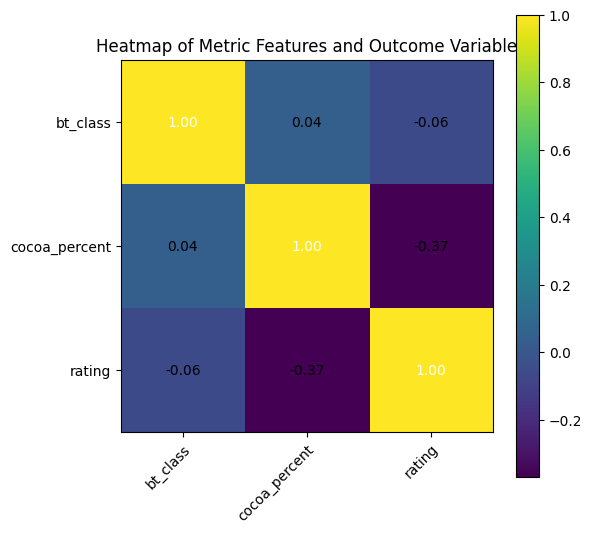

From the heatmap, it seems that the metric features chosen have nearly
no correlation with the bean type. This indicates that cocoa_percent
and rating both seem to not have an impact on the bean type. Putting it
another way, even if we know either the cocoa_percent and/or the rating
of a particular bean, that will still give us very little to no useful
information on the type of that bean.


In [22]:
# YOUR CODE HERE

# Generating plots to investigate features and outcomes w/in training data
from mlxtend.plotting import heatmap
import seaborn as sns

# Creating df_train for EDA and a column of just the metric (and outcome) values
df_train = pd.concat(
    [Y_train, X_train],
    axis=1
)
df_metric_cols = ['bt_class', 'cocoa_percent', 'rating']

# Creating a correlation matrix of just the metric (and outcome) values
cm = df_train[df_metric_cols].corr().values

# Getting a heatmap based on the correlation matrix
hm = heatmap(
    cm,
    row_names=df_metric_cols,
    column_names=df_metric_cols,
    figsize=(6, 6)
)
plt.title('Heatmap of Metric Features and Outcome Variable')
plt.show()

print("From the heatmap, it seems that the metric features chosen have nearly")
print("no correlation with the bean type. This indicates that cocoa_percent")
print("and rating both seem to not have an impact on the bean type. Putting it")
print("another way, even if we know either the cocoa_percent and/or the rating")
print("of a particular bean, that will still give us very little to no useful")
print("information on the type of that bean.")

Text(0.5, 0.98, 'Scatterplot Matrix of Metric Features and Outcome Variable')

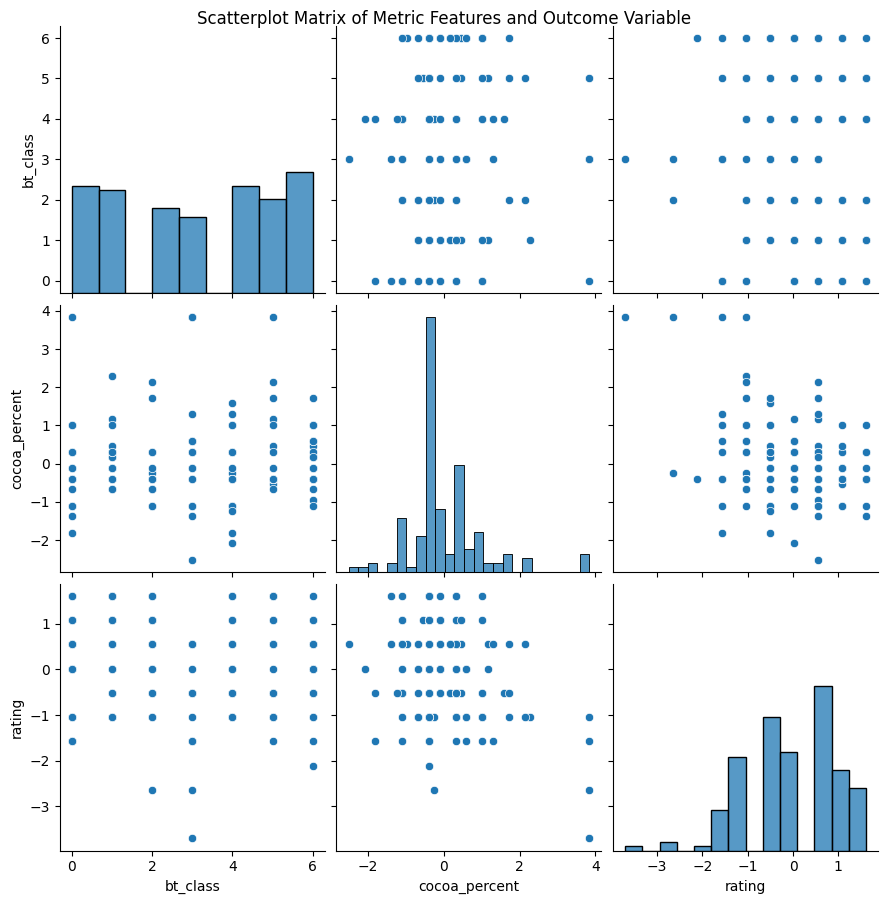

In [23]:
# Creating a pairplot of the metric features and outcome variable visualize
# their pair-wise correlations
sp = sns.pairplot(df_train[df_metric_cols], height = 3)
sp.fig.suptitle("Scatterplot Matrix of Metric Features and Outcome Variable",
                verticalalignment = 'bottom')

In [24]:
print("From the pairplot shown above, we confirm that there appears to be very")
print("little correlation between the metric features and the bean type. One")
print("positive takeaway is that the classes for bean type (bt_class) seem to")
print("at least be somewhat balanced, which will hopefully allow for better")
print("generalization. Another finding is that even though the data for")
print("cocoa_percent and rating do not seem to very normally distributed, the")
print("model does not require that condition, so we'll leave that as it is.\n")
print("Overall, based on the heatmap and pairplots, we can likely conclude")
print("that cocoa_percent and rating have little effect on the bean type, and")
print("that the model might need to rely more heavily on the broad origin")
print("features.")

From the pairplot shown above, we confirm that there appears to be very
little correlation between the metric features and the bean type. One
positive takeaway is that the classes for bean type (bt_class) seem to
at least be somewhat balanced, which will hopefully allow for better
generalization. Another finding is that even though the data for
cocoa_percent and rating do not seem to very normally distributed, the
model does not require that condition, so we'll leave that as it is.

Overall, based on the heatmap and pairplots, we can likely conclude
that cocoa_percent and rating have little effect on the bean type, and
that the model might need to rely more heavily on the broad origin
features.


---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [25]:
# YOUR CODE HERE

# 1. Implementing a baseline for the majority class
print("Most common bt_class in training data:", Y_train.value_counts().idxmax())
print("Number of labels in most common class:", Y_train.value_counts().max())
perc_major_class = Y_train.value_counts().max() / Y_train.shape[0]
print("Baseline prediction accuracy on training data:", perc_major_class)

# Initializing train and val baseline preds as ones
Y_train_baseline = np.ones((Y_train.shape[0], Y_train.nunique()))
Y_val_baseline = np.ones((Y_val.shape[0], Y_train.nunique()))

# Setting baseline arrays w/ original distribution of classes (percents) as the
# predicted probability for each class
for i in range(Y_train.nunique()):
  Y_train_baseline[:, i] = Y_train.value_counts()[i] / Y_train.shape[0]
  Y_val_baseline[:, i] = Y_train.value_counts()[i] / Y_train.shape[0]

print("Shape of Y_train_baseline:", Y_train_baseline.shape)
print("Shape of Y_val_baseline:", Y_val_baseline.shape)

Most common bt_class in training data: 6
Number of labels in most common class: 27
Baseline prediction accuracy on training data: 0.17419354838709677
Shape of Y_train_baseline: (155, 7)
Shape of Y_val_baseline: (52, 7)


In [26]:
# First 2 rows of Y_train_baseline as an example:
print("First 2 rows of Y_train_baseline as an example:")
print(Y_train_baseline[:2], '\n')
print("First 2 rows of Y_val_baseline as an example:")
print(Y_val_baseline[:2], '\n')

# Showing that the sum of the class percents is equal to 1
print("Sums of the first 2 rows of Y_train_baseline:",
  Y_train_baseline[:2].sum(axis = 1))
print("Sums of the first 2 rows of Y_val_baseline:",
  Y_val_baseline[:2].sum(axis = 1))

First 2 rows of Y_train_baseline as an example:
[[0.15483871 0.1483871  0.12258065 0.10967742 0.15483871 0.13548387
  0.17419355]
 [0.15483871 0.1483871  0.12258065 0.10967742 0.15483871 0.13548387
  0.17419355]] 

First 2 rows of Y_val_baseline as an example:
[[0.15483871 0.1483871  0.12258065 0.10967742 0.15483871 0.13548387
  0.17419355]
 [0.15483871 0.1483871  0.12258065 0.10967742 0.15483871 0.13548387
  0.17419355]] 

Sums of the first 2 rows of Y_train_baseline: [1. 1.]
Sums of the first 2 rows of Y_val_baseline: [1. 1.]


In [27]:
# 2. Implementing a function that computes the log loss metric and uses it to
# evaluate this baseline on both the Y_train and Y_val datasets

def compute_log_loss(preds, actual):

  # Number of samples
  m = actual.shape[0]

  # Getting the cross_entropy_values
  cross_entropy_values = -np.log(preds[range(m), actual])

  # Summing the cross entropy values across each observation
  loss = np.sum(cross_entropy_values) / m

  return loss

print('Baseline Log Loss on Y_train:',
  compute_log_loss(Y_train_baseline, Y_train))
print('Baseline Log Loss on Y_val:', compute_log_loss(Y_val_baseline, Y_val))

Baseline Log Loss on Y_train: 1.935718763045062
Baseline Log Loss on Y_val: 2.003628574856231


In [28]:
# Reflecting on what I know about the original distribution of classes in the
# training data

print("What we did was essentially setting the distribution of classes in the")
print("training data as our predictions. This works because the sum of the")
print("class percents adds up to 1, and it allows us to compare that with the")
print("true values of Y_train. It also has the benefit of not having any 0")
print("values (which we know because our X_train sample is roughly balanced),")
print("which makes the log step for the calculation of cross entropy values")
print("possible. If we did have values of 0 in any class, the cross entropy")
print("would shoot up to infinity.\n")
print("If our distribution had not been even, or if there were any 0s, we may")
print("have had to apply a softmax function. However, doing so would distort")
print("the probabilities because it exponentiates each value and normalizes")
print("them, giving more weight to the larger values. Thus, the majority class")
print("would be even more dominant, and the overall result will no longer")
print("reflect the actual training distribution. In our case, since the")
print("distribution was in fact roughly even (which we can also see when we")
print("look at the first few rows of Y_train_baseline or Y_val_baseline and")
print("notice that the values are not that far from each other), simply using")
print("raw class frequency percentages as our classification baseline should")
print("be sufficient.")

What we did was essentially setting the distribution of classes in the
training data as our predictions. This works because the sum of the
class percents adds up to 1, and it allows us to compare that with the
true values of Y_train. It also has the benefit of not having any 0
values (which we know because our X_train sample is roughly balanced),
which makes the log step for the calculation of cross entropy values
possible. If we did have values of 0 in any class, the cross entropy
would shoot up to infinity.

If our distribution had not been even, or if there were any 0s, we may
have had to apply a softmax function. However, doing so would distort
the probabilities because it exponentiates each value and normalizes
them, giving more weight to the larger values. Thus, the majority class
would be even more dominant, and the overall result will no longer
reflect the actual training distribution. In our case, since the
distribution was in fact roughly even (which we can also see when we
l

### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

In [29]:
# YOUR CODE HERE

# 1. Building a function to create and compile tf model
def build_model(num_features, learning_rate):

  # Resetting tf for consistent results
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Building a model using tf Sequential
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units = 7,
      input_shape = [num_features],
      use_bias = True,
      activation = 'softmax',
      kernel_initializer = initializers.RandomNormal(stddev=0.01),
      bias_initializer = initializers.RandomNormal(stddev=0.01)
  ))

  # Getting the optimizer
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Compiling the model
  model.compile(
      optimizer = optimizer,
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics = ['accuracy']
  )

  return model


In [30]:
tf.random.set_seed(1234)
np.random.seed(1234)

# Setting a learning rate, number of epochs, and batch size
learning_rate = 0.0001
num_epochs = 10
batch_size = 32

# Building and compiling the model
model_tf = build_model(
    X_train.shape[1], learning_rate = learning_rate
)

# 2. Training the model using the training dataset and passing the validation
# dataset for validation
model_tf_fit = model_tf.fit(
    x = X_train,
    y = Y_train,
    validation_data = [X_val, Y_val],
    epochs = num_epochs,
    batch_size = batch_size,
    verbose = 1
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - accuracy: 0.1701 - loss: 1.9431 - val_accuracy: 0.1923 - val_loss: 1.9441
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.1701 - loss: 1.9431 - val_accuracy: 0.1923 - val_loss: 1.9441
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1701 - loss: 1.9431 - val_accuracy: 0.1923 - val_loss: 1.9441
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.1701 - loss: 1.9430 - val_accuracy: 0.1923 - val_loss: 1.9440
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.1701 - loss: 1.9430 - val_accuracy: 0.1923 - val_loss: 1.9440
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.1701 - loss: 1.9430 - val_accuracy: 0.1923 - val_loss: 1.9440
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.1701 - loss: 1.9430 - val_accuracy: 0.1923 - val_loss: 1.9440
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1701 - loss: 1.9429 - val_accuracy: 0.1923 - val_loss: 1.9

In [31]:
# Showing the learned model
w = model_tf.layers[0].get_weights()[0].T
# ^tf gives the weights as (features x class), so need to transpose it
b = model_tf.layers[0].get_weights()[1]

print('Bias:', b)
print('Weights:', w)
w.shape

Bias: [-1.0821936e-02 -2.2739368e-03 -2.0131834e-03 -6.2218853e-03
 -9.2308364e-05  3.1626553e-03  1.4015350e-04]
Weights: [[ 8.26274790e-03 -5.96714485e-03 -5.18182432e-03 -1.15245599e-02
  -1.04587348e-02  4.81875194e-03 -6.85965363e-03 -2.65941699e-03
   5.59986709e-03 -9.36668739e-03  8.57754797e-03  1.35898767e-02
  -2.67518102e-03  1.16937580e-02  1.42448386e-02 -1.80910027e-03
  -5.51319029e-03  1.04832007e-02 -1.15214381e-02 -2.20899377e-02
   2.42536496e-02  2.01455131e-03 -3.82459303e-03  9.02665965e-03
   1.65427476e-02 -1.56056334e-03 -4.10495239e-04 -1.13621494e-02
   5.91176003e-03  9.74727329e-03 -1.29128341e-02 -1.69632323e-02
  -9.06441640e-03 -7.61130126e-03  6.99815154e-03]
 [ 8.55955109e-03 -1.85833208e-03 -5.28304838e-04 -2.04219483e-03
  -7.86982663e-03  1.48936324e-02  5.04953740e-03 -4.87013720e-03
  -1.84728689e-02  2.31109187e-02  1.37421396e-03  9.81570408e-03
   5.40001644e-03 -4.01381450e-03  6.47974201e-03 -1.58849768e-02
   1.78883541e-02  1.05251111e-02 

(7, 35)

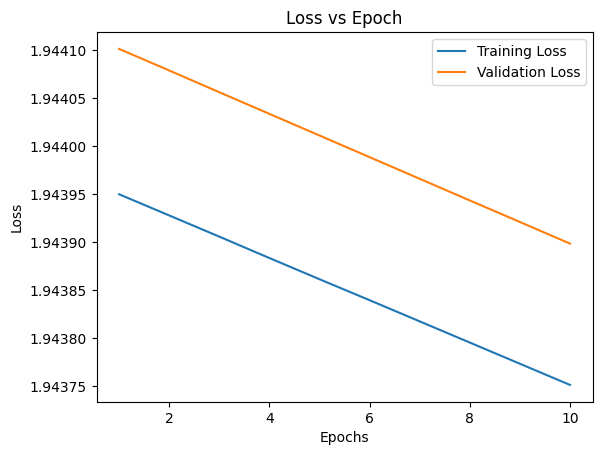

In [32]:
# 3. Generating a plot with loss on y-axis and epoch on x-axis
hist = model_tf_fit.history
plt.plot(range(1, num_epochs+1), hist['loss'], label='Training Loss')
plt.plot(range(1, num_epochs+1), hist['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

In [33]:
# YOUR CODE HERE
tf.random.set_seed(1234)
np.random.seed(1234)

# Manually fine tuning the learning rate, number of epochs, and batch size
num_epochs_m = 25
learning_rate_m = 0.999999
batch_size_m = 10
model_tf_m = build_model(num_features = X_train.shape[1],
    learning_rate = learning_rate_m)

# Training manual model
model_tf_m_fit = model_tf_m.fit(
    x = X_train,
    y = Y_train,
    validation_data = [X_val, Y_val],
    epochs = num_epochs_m,
    batch_size = batch_size_m,
    verbose = 1
)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.1769 - loss: 1.9133 - val_accuracy: 0.4038 - val_loss: 1.5953
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4418 - loss: 1.6335 - val_accuracy: 0.5192 - val_loss: 1.4311
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5268 - loss: 1.4785 - val_accuracy: 0.5385 - val_loss: 1.3400
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5487 - loss: 1.3836 - val_accuracy: 0.5385 - val_loss: 1.2838
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5576 - loss: 1.3192 - val_accuracy: 0.5385 - val_loss: 1.2459
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5587 - loss: 1.2718 - val_accuracy: 0.5385 - val_loss: 1.2187
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5624 - loss: 1.2348 - val_accuracy: 0.5577 - val_loss: 1.1985
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5824 - loss: 1.2049 - val_accuracy: 0.5577 - v

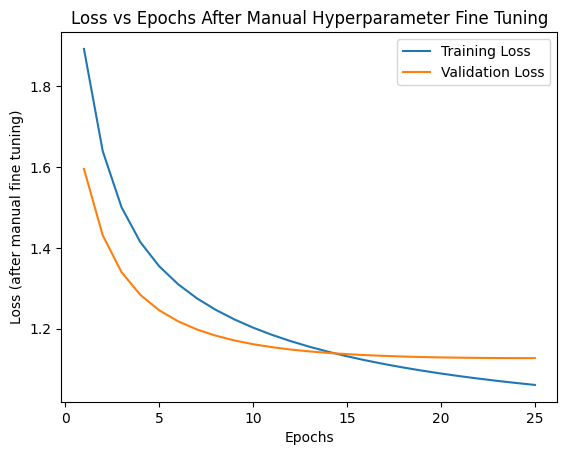

In [34]:
# Getting the history of the model
hist_m = model_tf_m_fit.history

# Plotting the loss vs epoch curve with tuned model
plt.plot(range(1, num_epochs_m+1), hist_m['loss'], label='Training Loss')
plt.plot(range(1, num_epochs_m+1), hist_m['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (after manual fine tuning)')
plt.title('Loss vs Epochs After Manual Hyperparameter Fine Tuning')
plt.legend()
plt.show()

In [35]:
print("Manually tuning the number of epochs, learning rate, and batch size")
print("ultimately yielded a curve that looks like the above. Some interesting")
print("findings are as follow:")
print(" - Increasing the number of epochs essentially gets the model to where")
print("it ultimately will go (at least for the training data). In other words,")
print("if the model were going to diverge, increasing the epochs will allow")
print("you to see that. If it were going to converge at a certain point, you")
print("will be able to see that as well. What it also does is show you when")
print("the validation loss starts reversing, as the model overfits and it gets")
print("worse and worse at predicting the validation dataset. The spot where")
print("the derivative of the validation loss is 0 (that reversal point) should")
print("theoretically be the ideal point to train to.")
print(" - Changing the learning rate allows our gradient descent algorithm to")
print("'run faster' essentially. In other words, having a higher learning rate")
print("should make the convergence happen faster. Normally, when the learning")
print("rate is too large, there is a chance that it will diverge as it shoots")
print("past the global minimum. However, since our model is just generally")
print("not great (as we saw in the heatmap and pairplots), even a high")
print("rate is not that large of an issue.")
print(" - Changing the batch size yielded the most interesting results. As")
print("demonstrated in a previous assignment, pure SGD with a batch size of")
print("1 causes the model to converge incredibly quickly, as the model will")
print("update the parameters after each data point. However, this will also")
print("introduce a lot of noise into the model, and you likely won't get to")
print("the ideal minimum you're looking for. Thus, decreasing the batch size")
print("to expedite the training of the model without overshooting it is")
print("paramount. Through manual testing, I found that a batch size of 10 was")
print("sufficient for the model to train relatively quickly, and without")
print("overfitting too much.")

Manually tuning the number of epochs, learning rate, and batch size
ultimately yielded a curve that looks like the above. Some interesting
findings are as follow:
 - Increasing the number of epochs essentially gets the model to where
it ultimately will go (at least for the training data). In other words,
if the model were going to diverge, increasing the epochs will allow
you to see that. If it were going to converge at a certain point, you
will be able to see that as well. What it also does is show you when
the validation loss starts reversing, as the model overfits and it gets
worse and worse at predicting the validation dataset. The spot where
the derivative of the validation loss is 0 (that reversal point) should
theoretically be the ideal point to train to.
 - Changing the learning rate allows our gradient descent algorithm to
'run faster' essentially. In other words, having a higher learning rate
should make the convergence happen faster. Normally, when the learning
rate is too l

In [36]:
print("Checking out the accuracy shows us that it's still not great:")
print(" - Training accuracy:", model_tf_m.evaluate(X_train, Y_train, verbose = 0)[1])
print(" - Validation accuracy:", model_tf_m.evaluate(X_val, Y_val, verbose = 0)[1])

print(f"\nHowever, compared with the original accuracy ({perc_major_class:.5f}),")
print("it's definitely better in comparison.")

Checking out the accuracy shows us that it's still not great:
 - Training accuracy: 0.6645161509513855
 - Validation accuracy: 0.5769230723381042

However, compared with the original accuracy (0.17419),
it's definitely better in comparison.


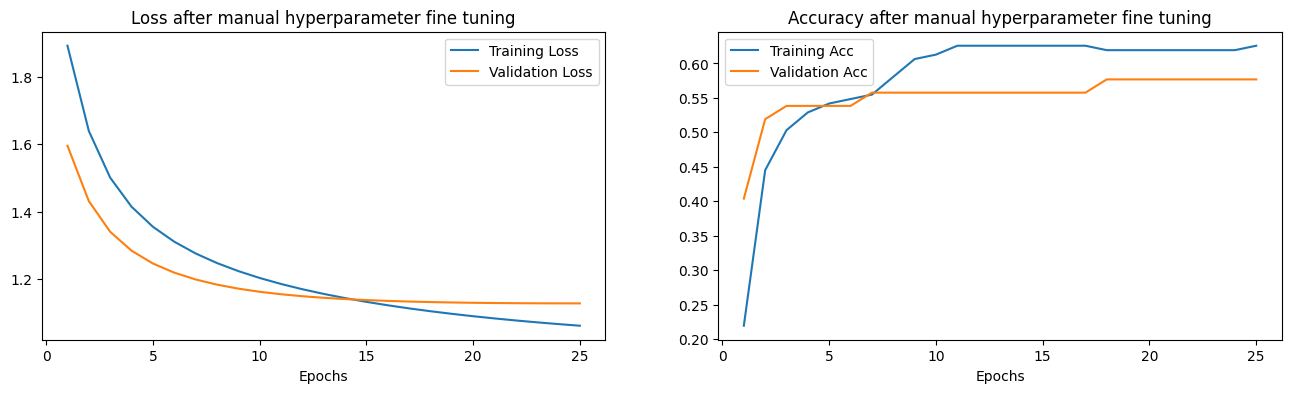

In [37]:
# Plotting the loss on the first subplot
fig = plt.figure(figsize = (16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(range(1, num_epochs_m+1), hist_m['loss'], label='Training Loss')
plt.plot(range(1, num_epochs_m+1), hist_m['val_loss'], label='Validation Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_title('Loss after manual hyperparameter fine tuning');

# Plotting the accuracy on the second subplot
ax = fig.add_subplot(1, 2, 2)
plt.plot(range(1, num_epochs_m+1), hist_m['accuracy'], label='Training Acc')
plt.plot(range(1, num_epochs_m+1), hist_m['val_accuracy'], label='Validation Acc')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_title('Accuracy after manual hyperparameter fine tuning')
plt.show()

In [38]:
print("Overall, the loss after manual hyperparameter tuning showed that the")
print("training loss ended at:", hist_m['loss'][-1])
print("and the validation loss ended at:", hist_m['val_loss'][-1], '\n')

print("These are perhaps not great compared to what we've seen in previous")
print("assignments, but they're still better than our baseline:")
print("Y_train_baseline loss:", compute_log_loss(Y_train_baseline, Y_train))
print("Y_val_baseline loss:", compute_log_loss(Y_val_baseline, Y_val))

Overall, the loss after manual hyperparameter tuning showed that the
training loss ended at: 1.0611215829849243
and the validation loss ended at: 1.1274081468582153 

These are perhaps not great compared to what we've seen in previous
assignments, but they're still better than our baseline:
Y_train_baseline loss: 1.935718763045062
Y_val_baseline loss: 2.003628574856231


In [39]:
# We will now try getting optimal hyperparameters using keras tuner

In [40]:
# Now using Keras Tuner:
def model_builder(hp):

  # Resetting tf for consistent results
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Building a model using tf Sequential
  model = tf.keras.Sequential()

  # Getting the input layer
  model.add(tf.keras.Input(shape=(35,), name='Input'))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))

  # Getting the output layer
  model.add(tf.keras.layers.Dense(
        units = 7,
        use_bias = True,
        activation = 'softmax',
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name='Output'
  ))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.999999, 0.9999, 0.99, or 0.9
  hp_learning_rate = hp.Choice('learning_rate', values=[999999e-6, 9999e-4, 99e-2, 9e-1])

  # Getting the optimizer
  optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  # ^from_logits = False means that you have a softmax activation in the last layer,
  # ^and that the model doesn't need to do it for you

  return model


In [41]:
# Instantiating Hyperband tuner (with the objective being the validation loss)
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     overwrite=True)

In [42]:
# Creating a callback to stop training early after reaching a certain value for
# the validation loss (i.e., if val_loss hasn't improved in 5 epochs, it will move on)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [43]:
# Running the hyperparameter search
tuner.search(X_train, Y_train, epochs=30, validation_data = [X_val, Y_val],
  callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps

Trial 65 Complete [00h 00m 04s]
val_loss: 1.3029468059539795

Best val_loss So Far: 1.1501095294952393
Total elapsed time: 00h 02m 28s


In [44]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.999999.



In [45]:
# Training the model (starting with building the model with the optimal)
# hyperparameters and training it on the data for 50 epochs
model_hp = tuner.hypermodel.build(best_hps)
history_hp = model_hp.fit(X_train, Y_train, epochs=50, validation_data=[X_val, Y_val])

val_loss_per_epoch = history_hp.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.2402 - loss: 1.9398 - val_accuracy: 0.2885 - val_loss: 1.8729
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3717 - loss: 1.8342 - val_accuracy: 0.3654 - val_loss: 1.7616
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5098 - loss: 1.7126 - val_accuracy: 0.4615 - val_loss: 1.6207
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5202 - loss: 1.5712 - val_accuracy: 0.4615 - val_loss: 1.4821
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5457 - loss: 1.4377 - val_accuracy: 0.5000 - val_loss: 1.3730
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5561 - loss: 1.3331 - val_accuracy: 0.5000 - val_loss: 1.2981
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5322 - loss: 1.2576 - val_accuracy: 0.5192 - val_loss: 1.2481
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5521 - loss: 1.2005 - val_accuracy: 0.5385 - val_loss: 1.2156


In [46]:
# Re-instantiating the hypermodel and training it with the optimal number of
# epochs from above
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_fit = hypermodel.fit(
    X_train,
    Y_train,
    epochs=best_epoch,
    validation_data = [X_val, Y_val],
    batch_size = 32)

Epoch 1/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.1994 - loss: 1.9407 - val_accuracy: 0.2885 - val_loss: 1.8747
Epoch 2/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3505 - loss: 1.8320 - val_accuracy: 0.3846 - val_loss: 1.7633
Epoch 3/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5172 - loss: 1.7067 - val_accuracy: 0.4615 - val_loss: 1.6186
Epoch 4/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5072 - loss: 1.5618 - val_accuracy: 0.4808 - val_loss: 1.4779
Epoch 5/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4920 - loss: 1.4299 - val_accuracy: 0.5000 - val_loss: 1.3724
Epoch 6/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5050 - loss: 1.3315 - val_accuracy: 0.5192 - val_loss: 1.3003
Epoch 7/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5335 - loss: 1.2597 - val_accuracy: 0.5385 - val_loss: 1.2549
Epoch 8/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5630 - loss: 1.2055 - val_accuracy: 0.5385 - val_loss: 1.2234


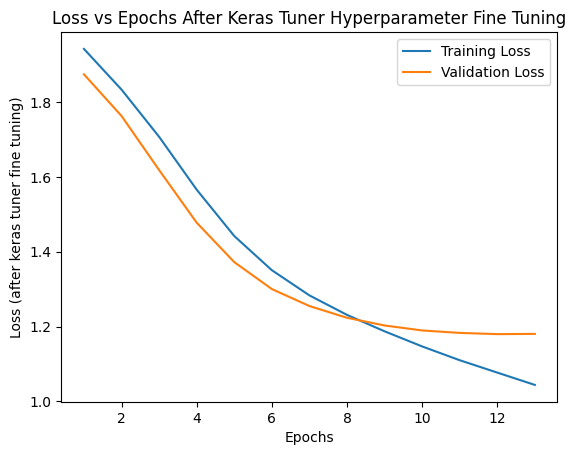

In [47]:
# Getting the history of the model
hist_t = hypermodel_fit.history

# Plotting the loss vs epoch curve with tuned model
plt.plot(range(1, best_epoch+1), hist_t['loss'], label='Training Loss')
plt.plot(range(1, best_epoch+1), hist_t['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (after keras tuner fine tuning)')
plt.title('Loss vs Epochs After Keras Tuner Hyperparameter Fine Tuning')
plt.legend()
plt.show()

In [49]:
print("As we can see from above, using Keras tuner got us the results, though")
print("one caveat is that we used learning rates from what we already knew, so")
print("we didn't bother testing other, smaller learning rates. In either case,")
print("the optimal parameters are as follow:\n")
print(best_hps.values, '\n')
print("and we see indeed that choosing a higher learning rate is fine.")

As we can see from above, using Keras tuner got us the results, though
one caveat is that we used learning rates from what we already knew, so
we didn't bother testing other, smaller learning rates. In either case,
the optimal parameters are as follow:

{'units': 320, 'learning_rate': 0.999999, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0034'} 

and we see indeed that choosing a higher learning rate is fine.


In [53]:
print("Checking out the accuracy shows us that it's still not great:")
print(" - Accuracy using Keras Tuner:")
print(" - Training accuracy:", hypermodel.evaluate(X_train, Y_train, verbose = 0)[1])
print(" - Validation accuracy:", hypermodel.evaluate(X_val, Y_val, verbose = 0)[1])

print("\nThe training accuracy was actually slightly worse than the previous,")
print("manual model, though the validation accuracy was miraculously the exact")
print("same:")
print(" - Accuracy via manual tuning:")
print(" - Training accuracy:", model_tf_m.evaluate(X_train, Y_train, verbose = 0)[1])
print(" - Validation accuracy:", model_tf_m.evaluate(X_val, Y_val, verbose = 0)[1])

Checking out the accuracy shows us that it's still not great:
 - Accuracy using Keras Tuner:
 - Training accuracy: 0.6580645442008972
 - Validation accuracy: 0.5769230723381042

The training accuracy was actually slightly worse than the previous,
manual model, though the validation accuracy was miraculously the exact
same:
 - Accuracy via manual tuning:
 - Training accuracy: 0.6645161509513855
 - Validation accuracy: 0.5769230723381042


In [54]:
print("The caveat here is that we added another dense, hidden layer with")
print("variable units into our model. This is done because the keras tutorial")
print("shows them doing so. However, this is somewhat artificially boosting")
print("how well this model does, and we want to instead just use what we know")
print("thus far about the hyperparameters we should vary. In other words, we")
print("should try varying only the following three hyperparameters: number of")
print("epochs, learning rate, and batch size.")

The caveat here is that we added another dense, hidden layer with
variable units into our model. This is done because the keras tutorial
shows them doing so. However, this is somewhat artificially boosting
how well this model does, and we want to instead just use what we know
thus far about the hyperparameters we should vary. In other words, we
should try varying only the following three hyperparameters: number of
epochs, learning rate, and batch size.


In [55]:
print("Since batch size is not a hyperparameter we can automatically vary in")
print("the hypermodel, we will need to create our own class that has the")
print("option to vary the batch size.")

Since batch size is not a hyperparameter we can automatically vary in
the hypermodel, we will need to create our own class that has the
option to vary the batch size.


In [56]:
# Building custom hypermodel class to alter the batch size
# Citing github link for inspiration:
# https://github.com/keras-team/keras-tuner/issues/122
class MyHyperModel(kt.HyperModel):
  def build(self, hp):

    # Resetting tf for consistent results
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Building a model using tf Sequential
    model = tf.keras.Sequential()

    # Getting the input layer
    model.add(tf.keras.Input(shape=(35,), name='Input'))

    # The following code is now removed since we do not want to add another
    # hidden layer to boost our model
    # hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    # model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))

    # Getting the output layer
    model.add(tf.keras.layers.Dense(
          units = 7,
          use_bias = True,
          activation = 'softmax',
          kernel_initializer=initializers.RandomNormal(stddev=0.01),
          bias_initializer=initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))

    # Tuning the learning rate for the optimizer
    # Choose an optimal value from 0.999999, 0.9999, 0.99, or 0.9
    hp_learning_rate = hp.Choice('learning_rate', values=[999999e-6, 9999e-4, 99e-2, 9e-1])

    # Getting the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    # ^from_logits = False means that you have a softmax activation in the last layer,
    # ^and that the model doesn't need to do it for you

    return model

  # This is where we add the batch size, and based on our results from the
  # manual tuning, we will have one of 4 possible batch sizes: [8, 16, 24, 32]
  def fit(self, hp, model, *args, **kwargs):
      return model.fit(
          *args,
          batch_size=hp.Choice("batch_size", [8, 16, 24, 32]),
          **kwargs,
      )


In [57]:
# Instantiating Hyperband tuner (with the objective being the validation loss)
tuner_c = kt.Hyperband(MyHyperModel(),
    objective="val_loss",
    max_epochs=100,
    factor=3,
    # hyperband_iterations=5,  # Note to self: do NOT set this number too high,
    # ^as it will burn through your compute; what this does is tell the model
    # how many times to iterate over the whole hyperband algorithm, so the more
    # that it does, the more compute is requires
    overwrite=True
)

In [58]:
# Creating a callback to stop training early after reaching a certain value for
# the validation loss (i.e., if val_loss hasn't improved in 5 epochs, it will move on)
stop_early_c = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [59]:
# Running the hyperparameter search
tuner_c.search(X_train, Y_train, epochs=100, validation_data = [X_val, Y_val],
  callbacks=[stop_early_c])

# Get the optimal hyperparameters
best_hps_c = tuner_c.get_best_hyperparameters(num_trials=1)[0]
best_hps_c.values

Trial 16 Complete [00h 00m 03s]
val_loss: 1.618862271308899

Best val_loss So Far: 1.4017422199249268
Total elapsed time: 00h 00m 43s


{'learning_rate': 0.9999,
 'batch_size': 8,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [60]:
print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps_c.get('learning_rate')}, and the optimal batch size for the optimizer
is {best_hps_c.get('batch_size')}.
""")


The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.9999, and the optimal batch size for the optimizer
is 8.



In [61]:
print("One odd thing to take note of: we see in the above example that the")
print("apparent best val_loss so far is ~1.4; however, we'll see below that it")
print("is actually quite a bit better. This discrepancy is likely the case")
print("because of the Hyperband tuner itself. Essentially, Hyperband does not")
print("train every model for the max_epochs from the start, and it instead")
print("seems to follow an aggressive early stopping approach. This means that")
print("it first trains many models for a small number of epochs (like 1 or 2).")
print("Then, it eliminates the weak models based on the validation loss, and")
print("it allocates more epochs to better-performing models in later rounds.")
print("This means that only the best few models reach the max_epochs.")
print("The problem, however, is that the model might not improve very much")
print("through these 1 or 2 epochs, potentially because there's not enough")
print("for it to improve. This leads to early elimination, and the tuning")
print("process also stops quickly as well.\n")

print("To account for that, we can change the factor, which has a twofold")
print("purpose. Firstly, it's the reduction factor for the number of models -")
print("in other words, the number of models in each bracket - which is")
print("calculated as 1 + log_sub_factor(max_epochs). Thus, a greater factor")
print("would mean that there are fewer models in each bracket, giving each one")
print("more of a chance to remain in the running. Secondly, the factor")
print("(partially) determines the number of epochs that is run, at least in")
print("the beginning stages of the pruning process. For example, setting the")
print("factor to 20 with 100 max_epochs would give 5 (100/20) epochs run in")
print("the beginning of the process, which allows the validation loss to get a")
print("bit lower.\n")

print("This may lead us to think that we should indeed be lowering the factor,")
print("as doing so will give us more epochs. However, when we change the")
print("factor to 10 or lower (with 100 max_epochs), we actually only get a")
print("single epoch run. This doesn't seem to be able to be explained from the")
print("code or the documentation, and it may just be an idiosyncracy with")
print("Hyperband. Interestingly enough, setting the factor to 11 (and thus")
print("getting 10 epochs because 100/11 is 9.09 which rounds up to 10) does")
print("still work, and we'll stick with that instead. This will theoretically")
print("get us the greatest amount of epochs run while not allowing Hyperband")
print("to prune as aggressively, hopefully giving us a better validation loss")
print("at the end.")

One odd thing to take note of: we see in the above example that the
apparent best val_loss so far is ~1.4; however, we'll see below that it
is actually quite a bit better. This discrepancy is likely the case
because of the Hyperband tuner itself. Essentially, Hyperband does not
train every model for the max_epochs from the start, and it instead
seems to follow an aggressive early stopping approach. This means that
it first trains many models for a small number of epochs (like 1 or 2).
Then, it eliminates the weak models based on the validation loss, and
it allocates more epochs to better-performing models in later rounds.
This means that only the best few models reach the max_epochs.
The problem, however, is that the model might not improve very much
through these 1 or 2 epochs, potentially because there's not enough
for it to improve. This leads to early elimination, and the tuning
process also stops quickly as well.

To account for that, we can change the factor, which has a twofold


In [62]:
# Instantiating Hyperband tuner with a factor of 11
tuner_c_1 = kt.Hyperband(MyHyperModel(),
    objective="val_loss",
    max_epochs=100,
    factor=11,
    overwrite=True
)

In [63]:
# Running the hyperparameter search
tuner_c_1.search(X_train, Y_train, epochs=100, validation_data = [X_val, Y_val],
  callbacks=[stop_early_c])

# Get the optimal hyperparameters
best_hps_c_1 = tuner_c_1.get_best_hyperparameters(num_trials=1)[0]
best_hps_c_1.values

Trial 16 Complete [00h 00m 05s]
val_loss: 1.222745418548584

Best val_loss So Far: 1.161958932876587
Total elapsed time: 00h 01m 01s


{'learning_rate': 0.9999,
 'batch_size': 8,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [64]:
# Getting a summary of the results:
tuner_c_1.results_summary(num_trials = 1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 0014 summary
Hyperparameters:
learning_rate: 0.9999
batch_size: 8
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.161958932876587


In [65]:
print("Running it this way does give us the best validation loss so far,")
print("though the validation loss still does not seem to be as good as that")
print("from our manual search. One thing to try is a different tuner (instead")
print("of Hyperband). One that is recommended is the RandomSearch tuner;")
print("however, this proved to not be much better, as we can see below.")

Running it this way does give us the best validation loss so far,
though the validation loss still does not seem to be as good as that
from our manual search. One thing to try is a different tuner (instead
of Hyperband). One that is recommended is the RandomSearch tuner;
however, this proved to not be much better, as we can see below.


In [66]:
# Instantiating RandomSearch tuner (with the objective being the validation loss)
tuner_c_2 = kt.RandomSearch(MyHyperModel(),
    objective="val_loss",
    max_trials=30,
    overwrite=True
)

In [67]:
# Running the hyperparameter search
tuner_c_2.search(X_train, Y_train, epochs=10, validation_data = [X_val, Y_val],
  callbacks=[stop_early_c])

# Get the optimal hyperparameters
best_hps_c_2 = tuner_c_2.get_best_hyperparameters(num_trials=1)[0]
best_hps_c_2.values

Trial 16 Complete [00h 00m 04s]
val_loss: 1.1623365879058838

Best val_loss So Far: 1.1622601747512817
Total elapsed time: 00h 01m 04s


{'learning_rate': 0.9999, 'batch_size': 8}

In [70]:
print("Trying to switch optimizers (when building model) to a different one")
print("like Adam didn't change very much either. The last thing we might want")
print("to consider trying would be to build a custom training loop following")
print("the link below:")
print("https://keras.io/keras_tuner/guides/custom_tuner/")
print("However, this is very similar to what we've already done, and it likely")
print("won't change much because of the way Hyperband works. Overall, seeing")
print("as the validation loss we got from the tuner_c_1 (tuner class 1) model")
print("was the best, we will go with the parameters from that.")

Trying to switch optimizers (when building model) to a different one
like Adam didn't change very much either. The last thing we might want
to consider trying would be to build a custom training loop following
the link below:
https://keras.io/keras_tuner/guides/custom_tuner/
However, this is very similar to what we've already done, and it likely
won't change much because of the way Hyperband works. Overall, seeing
as the validation loss we got from the tuner_c_1 (tuner class 1) model
was the best, we will go with the parameters from that.


In [71]:
# Training the model the same way as before, but using the tuner class above
model_hp_c_1 = tuner_c_1.hypermodel.build(best_hps_c_1)
history_hp_c_1 = model_hp_c_1.fit(X_train, Y_train, epochs=100,
  batch_size=best_hps_c_1.get('batch_size'), validation_data=[X_val, Y_val])

val_loss_per_epoch_c_1 = history_hp_c_1.history['val_loss']
best_epoch_c_1 = val_loss_per_epoch_c_1.index(min(val_loss_per_epoch_c_1)) + 1
print('Best epoch: %d' % (best_epoch_c_1,))

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1800 - loss: 1.9073 - val_accuracy: 0.4231 - val_loss: 1.5754
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4697 - loss: 1.5923 - val_accuracy: 0.5000 - val_loss: 1.4029
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5188 - loss: 1.4326 - val_accuracy: 0.5577 - val_loss: 1.3149
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5728 - loss: 1.3419 - val_accuracy: 0.5385 - val_loss: 1.2636
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5911 - loss: 1.2824 - val_accuracy: 0.5385 - val_loss: 1.2303
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5840 - loss: 1.2393 - val_accuracy: 0.5577 - val_loss: 1.2074
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5856 - loss: 1.2060 - val_accuracy: 0.5577 - val_loss: 1.1910
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5872 - loss: 1.1792 - val_accuracy: 0.5577 - 

In [72]:
# Getting the final optimized metrics
model_hp_c_1.optimizer.get_config()

{'name': 'SGD',
 'learning_rate': 0.9998999834060669,
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'loss_scale_factor': None,
 'gradient_accumulation_steps': None,
 'momentum': 0.0,
 'nesterov': False}

In [73]:
# Re-instantiating the hypermodel and training it with the optimal number of
# epochs from above
hypermodel_c_1 = tuner_c_1.hypermodel.build(best_hps_c_1)

# Retrain the model
hypermodel_c_1_fit = hypermodel_c_1.fit(
    X_train,
    Y_train,
    epochs=best_epoch_c_1,
    validation_data = [X_val, Y_val],
    batch_size = best_hps_c_1.get('batch_size'))

Epoch 1/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2443 - loss: 1.9073 - val_accuracy: 0.4231 - val_loss: 1.5739
Epoch 2/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4697 - loss: 1.5927 - val_accuracy: 0.5000 - val_loss: 1.4018
Epoch 3/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5289 - loss: 1.4330 - val_accuracy: 0.5577 - val_loss: 1.3138
Epoch 4/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5728 - loss: 1.3422 - val_accuracy: 0.5385 - val_loss: 1.2624
Epoch 5/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5911 - loss: 1.2827 - val_accuracy: 0.5385 - val_loss: 1.2290
Epoch 6/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5840 - loss: 1.2395 - val_accuracy: 0.5577 - val_loss: 1.2060
Epoch 7/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5856 - loss: 1.2062 - val_accuracy: 0.5577 - val_loss: 1.1896
Epoch 8/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5856 - loss: 1.1793 - val_accuracy: 0.5577 - val_los

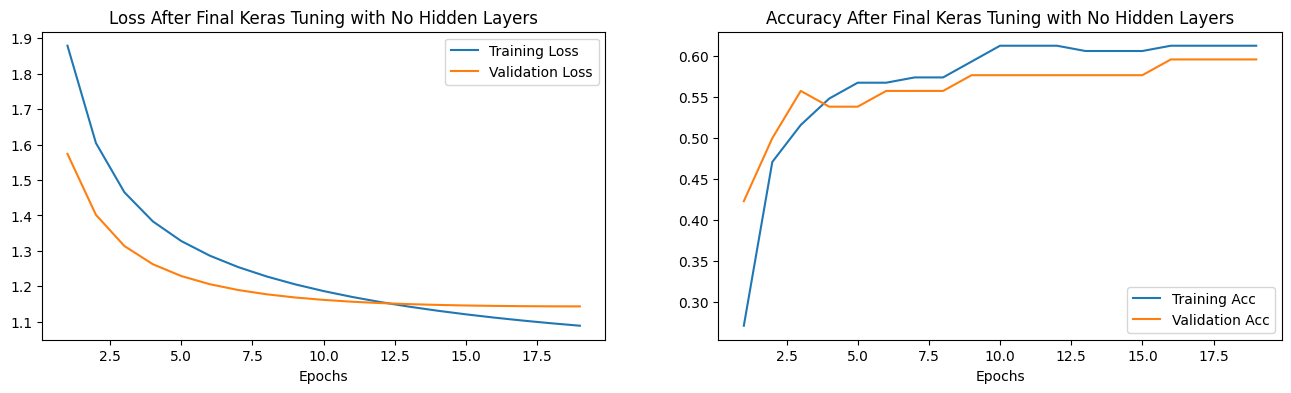

In [74]:
# Getting the history of the model
hist_c_1 = hypermodel_c_1_fit.history

# Plotting the loss of the final keras tuned model on the first subplot
fig = plt.figure(figsize = (16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(range(1, best_epoch_c_1+1), hist_c_1['loss'], label='Training Loss')
plt.plot(range(1, best_epoch_c_1+1), hist_c_1['val_loss'], label='Validation Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_title('Loss After Final Keras Tuning with No Hidden Layers');

# Plotting the accuracy of the final keras tuned model on the second subplot
ax = fig.add_subplot(1, 2, 2)
plt.plot(range(1, best_epoch_c_1+1), hist_c_1['accuracy'], label='Training Acc')
plt.plot(range(1, best_epoch_c_1+1), hist_c_1['val_accuracy'], label='Validation Acc')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_title('Accuracy After Final Keras Tuning with No Hidden Layers')
plt.show()

In [76]:
print("In the end, we see that our keras tuner model yielded seemingly decent")
print("results, with an accuracy and validation loss at least comparable to")
print("the previously trained model with the hidden layers. For now, we will")
print("move forward with the manual model (model_tf_m) and this hyperparameter")
print("tuned model (hypermodel_c_1), and we'll finish off the assignment with")
print("both.")

In the end, we see that our keras tuner model yielded seemingly decent
results, with an accuracy and validation loss at least comparable to
the previously trained model with the hidden layers. For now, we will
move forward with the manual model (model_tf_m) and this hyperparameter
tuned model (hypermodel_c_1), and we'll finish off the assignment with
both.


In [77]:
# 2. Getting the five five learned parameters of the models

# Getting the first five parameters from the manual model
print("2. The first five parameters for the features of the manually tuned")
print("model are:")
print(model_tf_m.layers[0].get_weights()[0][:5], '\n')
print("The learned parameter for the bias term of the manually tuned model is:")
print(model_tf_m.layers[0].get_weights()[1], '\n')

print("############\n")

# Getting the first five parameters from the keras tuned hyperparameter model
print("The first five parameters for the features of the keras tuner model are:")
print(hypermodel_c_1.layers[0].get_weights()[0][:5], '\n')
print("The learned parameter for the bias term of the keras tuner model is:")
print(hypermodel_c_1.layers[0].get_weights()[1], '\n')

2. The first five parameters for the features of the manually tuned
model are:
[[-0.04060517  0.5066174  -0.21429858 -0.63239706 -0.0215977   0.10738069
   0.29083785]
 [-0.21396032  0.22693662 -0.01093128 -0.6946085  -0.03104626  0.30456358
   0.38641396]
 [-0.6091659  -0.383848    0.8606942  -0.15639564 -0.58950603 -0.21632887
   1.1041939 ]
 [-0.7076419   1.4846903   0.8944829  -0.15074508 -0.6405317  -0.21952805
  -0.67833334]
 [-0.4260139  -0.24640076 -0.28339982 -0.06456551  1.5472465  -0.13636212
  -0.39655238]] 

The learned parameter for the bias term of the manually tuned model is:
[ 0.67383695  0.15182185  1.0503033  -2.1826656   0.63092077 -1.1226308
  0.81911117] 

############

The first five parameters for the features of the keras tuner model are:
[[ 0.01830162  0.49379444 -0.2607533  -0.65784085 -0.0077664  -0.01432826
   0.41067776]
 [-0.2648664   0.20755209  0.08395471 -0.7614659  -0.01202773  0.16368979
   0.5898389 ]
 [-0.57000095 -0.3782774   0.8327762  -0.1734709

In [78]:
# 3. Getting the loss at the final epoch on both the training and validation
# sets for both the manually tuned model and the keras tuner model

print("3. For the manually tuned model:")
print("Loss at the final epoch on the training set:", hist_m['loss'][-1])
print("Loss at the final epoch on the validation set:", hist_m['val_loss'][-1])

print("\nFor the keras tuner model:")
print("Loss at the final epoch on the training set:", hist_c_1['loss'][-1])
print("Loss at the final epoch on the validation set:", hist_c_1['val_loss'][-1])

3. For the manually tuned model:
Loss at the final epoch on the training set: 1.0611215829849243
Loss at the final epoch on the validation set: 1.1274081468582153

For the keras tuner model:
Loss at the final epoch on the training set: 1.088792324066162
Loss at the final epoch on the validation set: 1.1433671712875366


In [79]:
# 4. Getting the percentage difference between the losses observed on the
# training and validation datasets

print("4. The percentage difference between the losses observed on the")
print("training and validation datasets for the manually tuned model is: " + str(
  round((hist_m['loss'][-1] - hist_m['val_loss'][-1]) / hist_m['loss'][-1] * 100, 2)) + "%")

print("\nThe percentage difference between the losses observed on the training")
print("and validation datasets for the keras tuner model is: " + str(
  round((hist_c_1['loss'][-1] - hist_c_1['val_loss'][-1]) / hist_c_1['loss'][-1] * 100, 2)) + "%")

4. The percentage difference between the losses observed on the
training and validation datasets for the manually tuned model is: -6.25%

The percentage difference between the losses observed on the training
and validation datasets for the keras tuner model is: -5.01%


In [80]:
# 5. Comparing the training/vlidation loss of the TensorFlow models with the
# baseline model's loss

print("5. Comparing the TensorFlow models's losses against the baseline loss")
print("on Y_train:\n")
print(" - Manually tuned model_tf loss on Y_train:", hist_m['loss'][-1])
print(" - Manually tuned model_tf loss on Y_val:", hist_m['val_loss'][-1])
print(" - ")
print(" - Keras tuner hypermodel_c_1 loss on Y_train:", hist_c_1['loss'][-1])
print(" - Keras tuner hypermodel_c_1 loss on Y_val:", hist_c_1['val_loss'][-1])
print(" - ")
print(" - Baseline loss on Y_train:", compute_log_loss(Y_train_baseline, Y_train))
print(" - Baseline loss on Y_val:", compute_log_loss(Y_val_baseline, Y_val), '\n')

print("Comparing both the training and validation losses of the TensorFlow")
print("models with those of the baseline model, we see that both the manually")
print("tuned model and the keras tuner model demonstrate an improvement over")
print("the baseline model, as the losses for both are lower than those for the")
print("baseline.")


5. Comparing the TensorFlow models's losses against the baseline loss
on Y_train:

 - Manually tuned model_tf loss on Y_train: 1.0611215829849243
 - Manually tuned model_tf loss on Y_val: 1.1274081468582153
 - 
 - Keras tuner hypermodel_c_1 loss on Y_train: 1.088792324066162
 - Keras tuner hypermodel_c_1 loss on Y_val: 1.1433671712875366
 - 
 - Baseline loss on Y_train: 1.935718763045062
 - Baseline loss on Y_val: 2.003628574856231 

Comparing both the training and validation losses of the TensorFlow
models with those of the baseline model, we see that both the manually
tuned model and the keras tuner model demonstrate an improvement over
the baseline model, as the losses for both are lower than those for the
baseline.


---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [81]:
# YOUR CODE HERE

# 1. Running the manually tuned trained model on the train and test datasets and
# getting the greatest predictions using argmax
Y_train_pred_m = model_tf_m.predict(x=X_train)
Y_test_pred_m = model_tf_m.predict(x=X_test)

Y_train_pred_m = np.argmax(Y_train_pred_m, axis = 1)
Y_test_pred_m = np.argmax(Y_test_pred_m, axis = 1)

# Running the keras tuner trained model on the train and test datasets and
# getting the greatest predictions using argmax
Y_train_pred_c = hypermodel_c_1.predict(x=X_train)
Y_test_pred_c = hypermodel_c_1.predict(x=X_test)

Y_train_pred_c = np.argmax(Y_train_pred_c, axis = 1)
Y_test_pred_c = np.argmax(Y_test_pred_c, axis = 1)

print("\n1. For the manually tuned model:")
print("Aggregate training accuracy using tf.keras.metrics.Accuracy():",
  tf.keras.metrics.Accuracy()(Y_train, Y_train_pred_m).numpy())
print("Aggregate training accuracy using model.evaluate():",
  model_tf_m.evaluate(X_train, Y_train, verbose = 0)[1], '\n')
print("Aggregate test accuracy using tf.keras.metrics.Accuracy():",
  tf.keras.metrics.Accuracy()(Y_test, Y_test_pred_m).numpy())
print("Aggregate test accuracy using model.evaluate():",
  model_tf_m.evaluate(X_test, Y_test, verbose = 0)[1], '\n')

print("############\n")

print("For the keras tuner model:")
print("Aggregate training accuracy using tf.keras.metrics.Accuracy():",
  tf.keras.metrics.Accuracy()(Y_train, Y_train_pred_c).numpy())
print("Aggregate training accuracy using model.evaluate():",
  hypermodel_c_1.evaluate(X_train, Y_train, verbose = 0)[1], '\n')
print("Aggregate test accuracy using tf.keras.metrics.Accuracy():",
  tf.keras.metrics.Accuracy()(Y_test, Y_test_pred_c).numpy())
print("Aggregate test accuracy using model.evaluate():",
  hypermodel_c_1.evaluate(X_test, Y_test, verbose = 0)[1], '\n')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

1. For the manually tuned model:
Aggregate training accuracy using tf.keras.metrics.Accuracy(): 0.66451615
Aggregate training accuracy using model.evaluate(): 0.6645161509513855 

Aggregate test accuracy using tf.keras.metrics.Accuracy(): 0.5576923
Aggregate test accuracy using model.evaluate(): 0.557692289352417 

############

For the keras tuner model:
Aggregate training accuracy using tf.keras.metrics.Accuracy(): 0.62580645
Aggregate training accuracy using model.evaluate(): 0.625806450843811 

Aggregate test accuracy using tf.keras.metrics.Accuracy(): 0.5192308
Aggregate test accuracy using model.evaluate(): 0.5192307829856873 



In [84]:
# 2. Analyzing how well the model generalizes

print("2. Neither the manually tuned model nor the keras tuner model seem to")
print("demonstrate strong aggregate generalization capabilities. In both")
print("models, the test accuracy was roughly 10% lower than the training")
print("accuracy, which was already not great to begin with. Furthermore, the")
print("keras tuner model seemed to perform even worse than the manually")
print("trained model. This might be because of the Hyperband tuner itself, or")
print("it's because of human error and my miscomprehension of how the tuner")
print("works. In either case, the aggregate test accuracy still wasn't great,")
print("even with all the features included.\n")

print("One saving grace is that both models at least compare more favorably to")
print("the baseline, which - since it predicted the major class for all the")
print(f"data - was around {perc_major_class:.5f}.")


2. Neither the manually tuned model nor the keras tuner model seem to
demonstrate strong aggregate generalization capabilities. In both
models, the test accuracy was roughly 10% lower than the training
accuracy, which was already not great to begin with. Furthermore, the
keras tuner model seemed to perform even worse than the manually
trained model. This might be because of the Hyperband tuner itself, or
it's because of human error and my miscomprehension of how the tuner
works. In either case, the aggregate test accuracy still wasn't great,
even with all the features included.

One saving grace is that both models at least compare more favorably to
the baseline, which - since it predicted the major class for all the
data - was around 0.17419.


### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

In [85]:
# YOUR CODE HERE

# 1. Generating a confusion matrix for the manually tuned model on the test
# dataset using tf.math:
conf_matrix_m = tf.math.confusion_matrix(
    Y_test,
    Y_test_pred_m,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
print("1. Generating the confusion matrix for the manually tuned model using")
print("tf.math:")
conf_matrix_m

1. Generating the confusion matrix for the manually tuned model using
tf.math:


<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[1, 2, 2, 0, 0, 2, 2],
       [0, 2, 1, 0, 0, 3, 0],
       [1, 0, 2, 1, 0, 0, 2],
       [0, 0, 0, 9, 0, 1, 0],
       [0, 1, 1, 0, 5, 0, 0],
       [0, 0, 0, 1, 0, 7, 0],
       [1, 1, 1, 0, 0, 0, 3]], dtype=int32)>

In [86]:
# Generating a confusion matrix for the keras tuner model on the test dataset
# using tf.math:
conf_matrix_c = tf.math.confusion_matrix(
    Y_test,
    Y_test_pred_c,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
print("Generating the confusion matrix for the manually tuned model using")
print("tf.math:")
conf_matrix_c

Generating the confusion matrix for the manually tuned model using
tf.math:


<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[2, 2, 2, 0, 0, 1, 2],
       [0, 2, 1, 0, 0, 3, 0],
       [1, 0, 2, 1, 0, 0, 2],
       [0, 0, 0, 9, 0, 0, 1],
       [1, 1, 0, 0, 5, 0, 0],
       [0, 0, 0, 2, 0, 4, 2],
       [1, 1, 1, 0, 0, 0, 3]], dtype=int32)>

In [87]:
# Defining a function to get the confusion matrix plot
def confusion_matrix_plot(conf_matrix, title):

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)

    plt.tight_layout()
    plt.show()

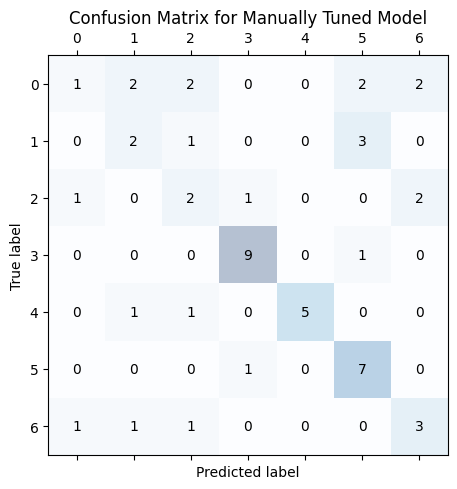

In [88]:
# Getting the confusion matrix for the manually tuned model
confusion_matrix_plot(conf_matrix_m.numpy(),
  'Confusion Matrix for Manually Tuned Model')

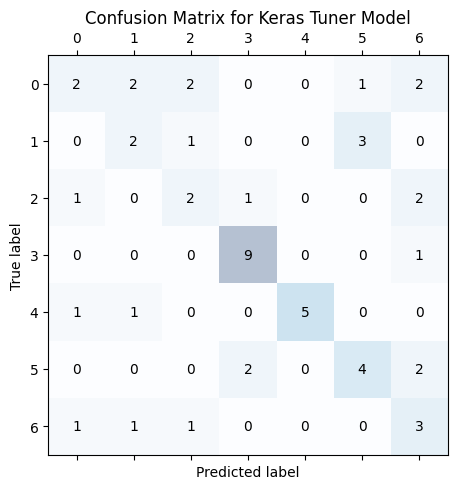

In [89]:
# Getting the confusion matrix for the keras tuner model
confusion_matrix_plot(conf_matrix_c.numpy(),
  'Confusion Matrix for Keras Tuner Model')

In [96]:
# 2. Determining which class has the lowest precision

print("Even for multiclass precision, this is defined as the number of True")
print("Positives over the sum of the True Positives and False Positives.\n")

print("2. Determining precision for each class from the manually tuned model:")
precision_m = sklearn.metrics.precision_score(Y_test, Y_test_pred_m, average=None)
tp_fp_sum_m = conf_matrix_m.numpy().sum(axis = 0)  # Sum of TP and FP
tp_m = np.diag(conf_matrix_m.numpy())  # Diagonal of conf_matrix_m (the TPs)
fp_m = tp_fp_sum_m - tp_m  # Just the FPs
print(precision_m)
print(" - The class with the lowest precision is: Class", np.argmin(precision_m))
print(" - The precision of the lowest precision class is:", min(precision_m))
print(" - The class with the largest source of false positives is:",
  np.argmax(fp_m), '\n')

print("Determining precision for each class from the keras tuner model:")
precision_c = sklearn.metrics.precision_score(Y_test, Y_test_pred_c, average=None)
tp_fp_sum_c = conf_matrix_c.numpy().sum(axis = 0)  # Sum of TP and FP
tp_c = np.diag(conf_matrix_c.numpy())  # Diagonal of conf_matrix_c (the TPs)
fp_c = tp_fp_sum_c - tp_c  # Just the FPs
print(precision_c)
print(" - The class with the lowest precision is: Class", np.argmin(precision_c))
print(" - The precision of the lowest precision class is:", min(precision_c))
print(" - The class with the largest source of false positives is:",
  np.argmax(fp_c), '\n')


Even for multiclass precision, this is defined as the number of True
Positives over the sum of the True Positives and False Positives.

2. Determining precision for each class from the manually tuned model:
[0.33333333 0.33333333 0.28571429 0.81818182 1.         0.53846154
 0.42857143]
 - The class with the lowest precision is: Class 2
 - The precision of the lowest precision class is: 0.2857142857142857
 - The class with the largest source of false positives is: 5 

Determining precision for each class from the keras tuner model:
[0.4        0.33333333 0.33333333 0.75       1.         0.5
 0.3       ]
 - The class with the lowest precision is: Class 6
 - The precision of the lowest precision class is: 0.3
 - The class with the largest source of false positives is: 6 



In [97]:
# 3. Determining which class has the lowest recall

print("Even for multiclass recall, this is defined as the number of True")
print("Positives over the sum of the True Positives and False Negatives.\n")

print("3. Determining recall for each class from the manually tuned model:")
recall_m = sklearn.metrics.recall_score(Y_test, Y_test_pred_m, average=None)
tp_fn_sum_m = conf_matrix_m.numpy().sum(axis = 1)  # Sum of TP and FN
fn_m = tp_fn_sum_m - tp_m  # Just the FNs
print(recall_m)
print(" - The class with the lowest recall is: Class", np.argmin(recall_m))
print(" - The recall of the lowest recall class is:", min(recall_m))
print(" - The class with the largest source of false negatives is:",
  np.argmax(fn_m), '\n')

print("Determining recall for each class from the keras tuner model:")
recall_c = sklearn.metrics.recall_score(Y_test, Y_test_pred_c, average=None)
tp_fn_sum_c = conf_matrix_c.numpy().sum(axis = 1)  # Sum of TP and FN
fn_c = tp_fn_sum_c - tp_c  # Just the FNs
print(recall_c)
print(" - The class with the lowest recall is: Class", np.argmin(recall_c))
print(" - The recall of the lowest recall class is:", min(recall_c))
print(" - The class with the largest source of false negatives is:",
  np.argmax(fn_c), '\n')


Even for multiclass recall, this is defined as the number of True
Positives over the sum of the True Positives and False Negatives.

3. Determining recall for each class from the manually tuned model:
[0.11111111 0.33333333 0.33333333 0.9        0.71428571 0.875
 0.5       ]
 - The class with the lowest recall is: Class 0
 - The recall of the lowest recall class is: 0.1111111111111111
 - The class with the largest source of false negatives is: 0 

Determining recall for each class from the keras tuner model:
[0.22222222 0.33333333 0.33333333 0.9        0.71428571 0.5
 0.5       ]
 - The class with the lowest recall is: Class 0
 - The recall of the lowest recall class is: 0.2222222222222222
 - The class with the largest source of false negatives is: 0 



In [93]:
print("Overall, the precision and recall scores for both models for most of")
print("the classes isn't great. However, this was expected as the overall")
print("accuracy wasn't great either. It would be interesting to see what the")
print("subgroup accuracies are, though there should theoretically not be much")
print("unfairness in the model, as the samples were evenly balanced in the")
print("beginning, and they were still pretty balanced in the training dataset.")

Overall, the precision and recall scores for both models for most of
the classes isn't great. However, this was expected as the overall
accuracy wasn't great either. It would be interesting to see what the
subgroup accuracies are, though there should theoretically not be much
unfairness in the model, as the samples were evenly balanced in the
beginning, and they were still pretty balanced in the training dataset.


----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [95]:
# YOUR CODE HERE

# Looking at the plots above, it definitely seems like the model is not very
# fair. Although we balanced the data, classes 3, 4, and 5 all seem to do pretty
# well in both models, while classes 0 and 2 consistently underperform, with low
# precision and recall rates. One explanation for this could be that class 0
# represents the blended bean type, which - as it's a blend - is inherently a
# mixture of the other chocolates. That's likely one large reason why the model
# performed the way it did, and removing the blended type could prove to be an
# interesting experiment in the future.